In [ ]:
# === 1. Import Library & Mount Google Drive ===
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# === 2. Atur Path Dataset Asli dan Bikin Folder Train/Val Otomatis ===
original_dataset = '/content/drive/MyDrive/dataset'
base_dir = '/content/dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Buat folder train/val kosong
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir)
os.makedirs(val_dir)

# Bagi data per kelas (80% train, 20% val)
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, class_name))
        os.makedirs(os.path.join(val_dir, class_name))

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

In [ ]:
# === 3. Image Generator + Augmentasi ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1104 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


In [ ]:
# === 4. Buat Model dengan MobileNetV2 ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Fine-tune nanti kalau perlu

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# === 5. Callback ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

In [ ]:
# === 6. Training ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, lr_reduce]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.4394 - loss: 1.3819 - val_accuracy: 0.7355 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6491 - loss: 0.8732 - val_accuracy: 0.8007 - val_loss: 0.4773 - learning_rate: 0.0010
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7204 - loss: 0.6699 - val_accuracy: 0.8225 - val_loss: 0.4261 - learning_rate: 0.0010
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7656 - loss: 0.5752 - val_accuracy: 0.8696 - val_loss: 0.3629 - learning_rate: 0.0010
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8035 - loss: 0.4863 - val_accuracy: 0.8623 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8037 - loss: 0.5049 - val_accuracy: 0.8696 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8279 - loss: 0.4087 - val_accuracy: 

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9280 - loss: 0.1971

Validation Accuracy: 0.9094
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


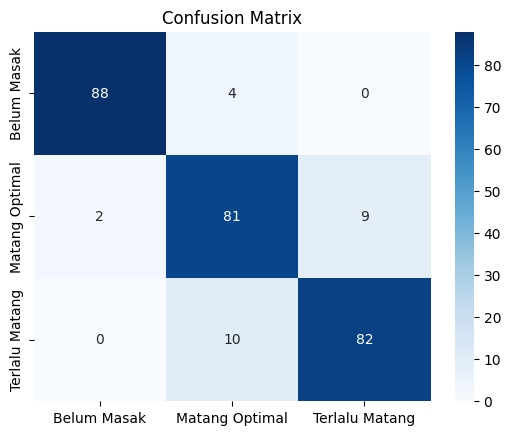


Classification Report:
                precision    recall  f1-score   support

   Belum Masak       0.98      0.96      0.97        92
Matang Optimal       0.85      0.88      0.87        92
Terlalu Matang       0.90      0.89      0.90        92

      accuracy                           0.91       276
     macro avg       0.91      0.91      0.91       276
  weighted avg       0.91      0.91      0.91       276



In [ ]:
# === 7. Evaluasi ===
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {val_acc:.4f}")

y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

# Laporan Klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

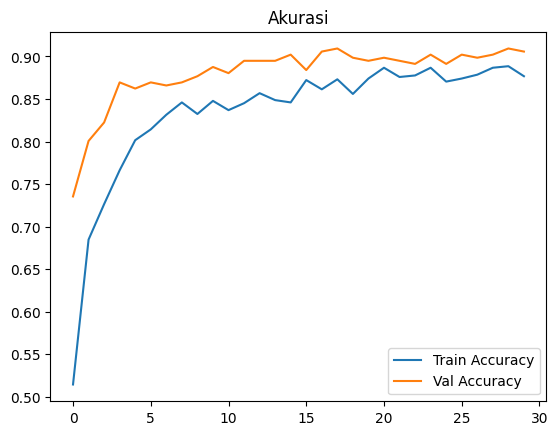

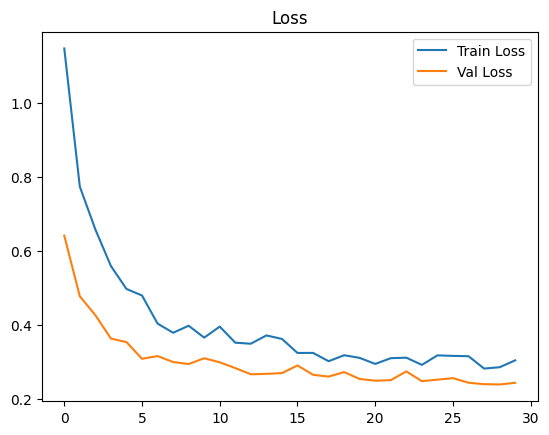

In [ ]:
# === 8. Visualisasi Akurasi dan Loss ===
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# === 9. Simpan Model ===
model.save('/content/drive/MyDrive/model_sawit_mobilenetv2_ver1.h5')

In [ ]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/drive/MyDrive/model_sawit_mobilenetv2_ver1.h5 \
    /content/drive/MyDrive/model_sawit_tfjs/

2025-05-04 02:31:48.636440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746325908.710961    2712 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746325908.725761    2712 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
